In [1]:
import os
import numpy as np
import pandas as pd
import sqlite3
from os import listdir
import plotly.express as px




In [2]:
meters_n96_2020 = pd.read_excel('/Users/cbianchi/Downloads/ERMA/meters.xlsx', sheet_name=0)['kWh'][:12]
meters_576esu_2020 = pd.read_excel('/Users/cbianchi/Downloads/ERMA/meters.xlsx', sheet_name='576 ESU')['kWh'][:12]
meters_14_hangar_2020 = pd.read_excel('/Users/cbianchi/Downloads/ERMA/meters.xlsx', sheet_name='14 Hangar1')['kWh'][:12]
meters_20_hangar_2020 = pd.read_excel('/Users/cbianchi/Downloads/ERMA/meters.xlsx', sheet_name='20 Hangar2')['kWh'][:12]
meters_15_hangar_2020 = pd.read_excel('/Users/cbianchi/Downloads/ERMA/meters.xlsx', sheet_name='15 Hangar3')['Monthly Elec kWh'][:12]
meters_N23_2020 = pd.read_excel('/Users/cbianchi/Downloads/ERMA/meters.xlsx', sheet_name='N23')['kWh'][:12]
meters_N2_2020 = pd.read_excel('/Users/cbianchi/Downloads/ERMA/meters.xlsx', sheet_name='N2')['kWh'][:12]
meters_Cuttermans_2020 = pd.read_excel('/Users/cbianchi/Downloads/ERMA/meters.xlsx', sheet_name='614 Cuttermans')['kWh'][:12]
meters_N73_2020 = pd.read_excel('/Users/cbianchi/Downloads/ERMA/meters.xlsx', sheet_name='N73')['kWh'][:12]
meters_R2_2020 = pd.read_excel('/Users/cbianchi/Downloads/ERMA/meters.xlsx', sheet_name='R2')['kWh'][:12]
meters_T1_2020 = pd.read_excel('/Users/cbianchi/Downloads/ERMA/meters.xlsx', sheet_name='T1')['Monthly Elec kWh'][:12]
# meters_T1_2020 = pd.read_excel('/Users/cbianchi/Downloads/ERMA/meters.xlsx', sheet_name='614 Cuttermans')['kWh'][:12]



meters_576esu_2020

0     22640
1     20000
2     22640
3     19360
4     18480
5     17040
6     19200
7     18880
8     17600
9     16080
10    17840
11    20400
Name: kWh, dtype: int64

NMBE
-3.0
CVRMSE
6.9


<AxesSubplot:>

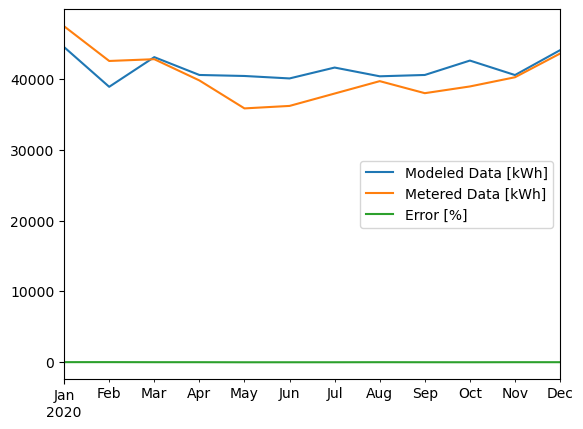

In [11]:
def return_path(sql_dir):
    sql_file = 'eplusout.sql'
    sql_path = os.path.join(sql_dir, sql_file)
    write_dir = sql_dir
    return sql_path

def return_values(sql_dir, line_number):
    sql_path = return_path(sql_dir)
    conn = sqlite3.connect(sql_path)
    c = conn.cursor()
#     query = "SELECT * FROM TabularDataWithStrings WHERE ReportName='AnnualBuildingUtilityPerformanceSummary' AND TableName='End Uses'"
    query = "SELECT * FROM ReportMeterDataDictionary "
    query = "SELECT VariableValue FROM ReportMeterData WHERE ReportMeterDataDictionaryIndex= " + str(line_number)
    end_uses = pd.read_sql(query ,conn) #J
#     print(end_uses)
    electric_kWh = end_uses*2.7778e-7
    return electric_kWh


def return_values_h(sql_dir, line_number):
    sql_path = return_path(sql_dir)
    conn = sqlite3.connect(sql_path)
    c = conn.cursor()
#     query = "SELECT * FROM TabularDataWithStrings WHERE ReportName='AnnualBuildingUtilityPerformanceSummary' AND TableName='End Uses'"
    query = "SELECT * FROM ReportMeterDataDictionary "
    query = "SELECT VariableValue FROM ReportMeterData WHERE ReportMeterDataDictionaryIndex= " + str(line_number)
    end_uses = pd.read_sql(query ,conn) #J
#     print(end_uses)
    
    electric_kWh = end_uses*2.7778e-7
    return electric_kWh


def Filter(string, substr):
    return [str for str in string if
             any(sub in str for sub in substr)]
    
def calculate_percentage(df, headers):
    df_perc = pd.DataFrame()
    for col in headers[:3]:
        df_perc[col] = df[col]        
    for col in headers[3:]:
        max_val = max(df[col])
        if max_val == 0:
            df_perc[col] = df[col]*0
        else:
            df_perc[col] = (df[col]/max_val*100).round(1)
            
    return df_perc
        
def monthly_df(sql_dir, meter, line_number):
    df = pd.DataFrame()
    df['Modeled Data [kWh]'] = return_values(sql_dir, line_number)['VariableValue']
    df['Metered Data [kWh]'] = meter

    df.index = pd.date_range("20200101", "20201231", freq='MS')
    df['Error [%]'] = ((df['Metered Data [kWh]']-df['Modeled Data [kWh]'])/df['Metered Data [kWh]']*100).round(1)
    
#     print('Annual Error')
#     print(((df['Modeled Data [kWh]'].sum()-df['Metered Data [kWh]'].sum())/df['Metered Data [kWh]'].sum()*100).round(1))

    print('NMBE')
    MBE = np.mean(df['Metered Data [kWh]'] - df['Modeled Data [kWh]'])
    NMBE = MBE*100*(1/np.mean(df['Metered Data [kWh]']))
    print(round(NMBE, 1))
    
    
    print('CVRMSE')
    m_mean = (np.mean(df['Metered Data [kWh]']))
    residuals = df['Metered Data [kWh]'] - df['Modeled Data [kWh]']
    residuals_squared = residuals**2
    sum_residuals_squared = sum(residuals**2)
    rmse_adj = (sum_residuals_squared/(len(df.index)))**0.5
    cvrmse_adj = rmse_adj/m_mean*100
    print(round(cvrmse_adj, 1))
    
#     print(((df['Metered Data [kWh]'] - df['Modeled Data [kWh]']).sum()/len(df.index)))
    
    return df


def hourly_df(sql_dir, meter, line_number, bldg_name):
    
    try:
        df = pd.DataFrame()
        df['Modeled Data [kWh]'] = return_values_h(sql_dir, line_number)['VariableValue']
    #     df['Metered Data [kWh]'] = meter

        df.index = pd.date_range(start='2020-01-01 00:00:00', end='2020-12-31 23:59:00', freq='10min')
        df = df.resample('1h').sum()
    except:
        df = pd.DataFrame()
        df['Modeled Data [kWh]'] = return_values_h(sql_dir, line_number)['VariableValue']
    #     df['Metered Data [kWh]'] = meter

        df.index = pd.date_range(start='2020-01-01 00:00:00', end='2020-12-31 23:59:00', freq='60min')
        df = df.resample('1h').sum()
    
    df.rename(columns = {'Modeled Data [kWh]': bldg_name + ' [kWh]'}, inplace = True)
    return df
    
    
    
# meter = meters_Cuttermans_2020
# sql_dir = '/Users/cbianchi/Downloads/ERMA/614_Cutterman_EH/run/in/run/'
# monthly_df(sql_dir, meter, 11).plot()



# meter = meters_N23_2020
# sql_dir = '/Users/cbianchi/Downloads/ERMA/N23_EH_2/run/in/run/'
# monthly_df(sql_dir, meter, 11).plot()

meter = meters_20_hangar_2020
sql_dir = '/Users/cbianchi/Downloads/ERMA/20_Hangar/run/in/run/'
monthly_df(sql_dir, meter, 11).plot()

# print(hourly_df(sql_dir, meter, 8, 'N73'))

# print(monthly_df(sql_dir, meter, 11))

#Increase some plug load
# Add electric heating as a plug load - attach it to some schedule

# list_dfs = []




In [345]:
meter = meters_n96_2020
sql_dir = '/Users/cbianchi/Downloads/ERMA/N96_2020/run/in/run/'



# monthly_df(sql_dir, meter, 11)
list_dfs.append(hourly_df(sql_dir, meter, 8, 'N96'))

In [346]:

meter = meters_14_hangar_2020
sql_dir = '/Users/cbianchi/Downloads/ERMA/14_Hangar/run/in/run/'

monthly_df(sql_dir, meter, 11)
list_dfs.append(hourly_df(sql_dir, meter, 8, '14 Hangar I'))


NMBE
4.3
CVRMSE
6.0


In [347]:
    
meter = meters_20_hangar_2020
sql_dir = '/Users/cbianchi/Downloads/ERMA/20_Hangar/run/in/run/'

monthly_df(sql_dir, meter, 11)
list_dfs.append(hourly_df(sql_dir, meter, 8, '20 Hangar II'))

NMBE
-0.6
CVRMSE
10.8


In [12]:
    
meter = meters_15_hangar_2020
sql_dir = '/Users/cbianchi/Downloads/ERMA/15_Hangar/run/in/run/'
# monthly_df(sql_dir, meter, 11).plot()

NMBE
-0.0
CVRMSE
11.6


<AxesSubplot:>

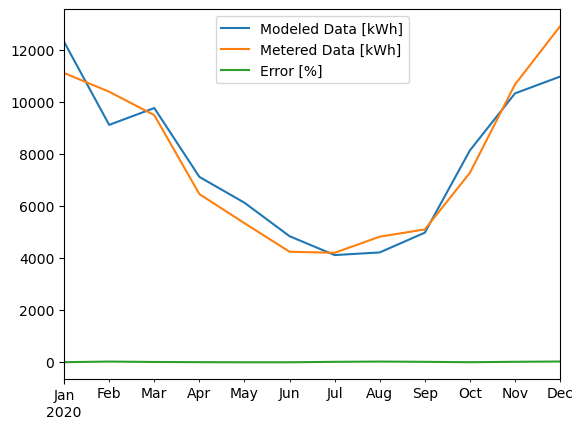

In [53]:
meter = meters_N23_2020
sql_dir = '/Users/cbianchi/Downloads/ERMA/N23/run/in/run/'
monthly_df(sql_dir, meter, 11).plot()


In [350]:
meter = meters_N2_2020
sql_dir = '/Users/cbianchi/Downloads/ERMA/N2/run/in/run/'

monthly_df(sql_dir, meter, 11)
list_dfs.append(hourly_df(sql_dir, meter, 8, 'N2'))

NMBE
-2.8
CVRMSE
6.0


NMBE
-1.7
CVRMSE
4.1


<AxesSubplot:>

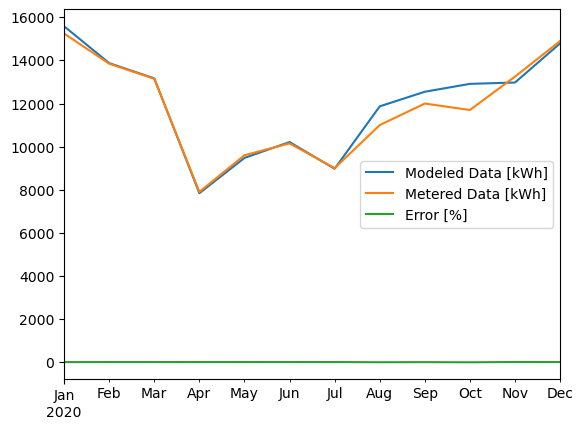

In [58]:
    
meter = meters_Cuttermans_2020
sql_dir = '/Users/cbianchi/Downloads/ERMA/614_Cutterman/run/in/run/'
monthly_df(sql_dir, meter, 11).plot()

In [352]:
meter = meters_N73_2020
sql_dir = '/Users/cbianchi/Downloads/ERMA/N73/run/in/run/'

monthly_df(sql_dir, meter, 11)
list_dfs.append(hourly_df(sql_dir, meter, 8, 'N73'))


NMBE
-3.1
CVRMSE
9.5


In [353]:
    
meter = meters_R2_2020
sql_dir = '/Users/cbianchi/Downloads/ERMA/R2/run/in/run/'

monthly_df(sql_dir, meter, 11)
list_dfs.append(hourly_df(sql_dir, meter, 8, 'R2'))

NMBE
2.2
CVRMSE
7.4


In [354]:
meter = meters_T1_2020
sql_dir = '/Users/cbianchi/Downloads/ERMA/T1/run/in/run/'

monthly_df(sql_dir, meter, 11)
list_dfs.append(hourly_df(sql_dir, meter, 8, 'T1'))


NMBE
2.0
CVRMSE
3.5


In [355]:
meter = meters_576esu_2020
sql_dir = '/Users/cbianchi/Downloads/ERMA/576ESU/run/in/run/'
monthly_df(sql_dir, meter, 11)
list_dfs.append(hourly_df(sql_dir, meter, 8, '576 ESU'))



NMBE
1.9
CVRMSE
9.5


In [356]:
meter = meters_576esu_2020
sql_dir = '/Users/cbianchi/Downloads/ERMA/MWD/run/in/run/'
monthly_df(sql_dir, meter, 11)
list_dfs.append(hourly_df(sql_dir, meter, 8, 'MWD'))



NMBE
43.7
CVRMSE
44.5


In [357]:
list_dfs

[                     N96 [kWh]
 2020-01-01 00:00:00   5.033341
 2020-01-01 01:00:00   5.332522
 2020-01-01 02:00:00   5.457181
 2020-01-01 03:00:00   5.806883
 2020-01-01 04:00:00   5.486918
 ...                        ...
 2020-12-31 19:00:00   4.999585
 2020-12-31 20:00:00   5.247336
 2020-12-31 21:00:00   4.824558
 2020-12-31 22:00:00   4.844367
 2020-12-31 23:00:00   5.401457
 
 [8784 rows x 1 columns],
                      14 Hangar I [kWh]
 2020-01-01 00:00:00         172.206096
 2020-01-01 01:00:00         171.695765
 2020-01-01 02:00:00         123.066239
 2020-01-01 03:00:00         123.677484
 2020-01-01 04:00:00         123.879115
 ...                                ...
 2020-12-31 19:00:00         160.529443
 2020-12-31 20:00:00         160.878771
 2020-12-31 21:00:00         160.528934
 2020-12-31 22:00:00         160.529507
 2020-12-31 23:00:00         160.878672
 
 [8784 rows x 1 columns],
                      20 Hangar II [kWh]
 2020-01-01 00:00:00          127.28372

In [361]:
aggregate_df = pd.concat(list_dfs, axis=1)
aggregate_df.to_csv('Electric_load_2020.csv')

In [ ]:
def return_values(sql_dir):
    sql_path = return_path(sql_dir)
    conn = sqlite3.connect(sql_path)
    c = conn.cursor()
#     query = "SELECT * FROM TabularDataWithStrings WHERE ReportName='AnnualBuildingUtilityPerformanceSummary' AND TableName='End Uses'"
    query = "SELECT * FROM ReportMeterDataDictionary "
    query = "SELECT VariableValue FROM ReportMeterData WHERE ReportMeterDataDictionaryIndex=11 "
    end_uses = pd.read_sql(query ,conn) #J
    electric_kWh = end_uses*2.7778e-7
#     electric_kWh = end_uses

    return electric_kWh
       


sql_dir = '/Users/cbianchi/Downloads/ERMA/N96_2020/run/in/run/'
full_n96_2020 = pd.DataFrame()
full_n96_2020['Modeled Data [kWh]'] = return_values(sql_dir)['VariableValue']
full_n96_2020['Metered Data [kWh]'] = meters_n96_2020
full_n96_2020.index = pd.date_range("20200101", "20201231", freq='MS')
# full_n96_2020['Error [%]'] = ((full_n96_2020['Modeled Data [kWh]']-full_n96_2020['Metered Data [kWh]'])/full_n96_2020['Modeled Data [kWh]']*100).round(1)

full_n96_2020





In [8]:
sql_dir = '/Users/cbianchi/Downloads/ERMA/14_Hangar_SEPARATE/run/in/run/'

sql_path = return_path(sql_dir)
conn = sqlite3.connect( '/Users/cbianchi/Downloads/ERMA/14_Hangar_SEPARATE/run/in/run/eplusout.sql')
c = conn.cursor()
query = "SELECT * FROM ReportMeterDataDictionary "
# query = "SELECT VariableValue FROM ReportMeterData WHERE ReportMeterDataDictionaryIndex=11 "
end_uses = pd.read_sql(query ,conn)
print(end_uses)

   ReportMeterDataDictionaryIndex VariableType               IndexGroup  \
0                               8          Sum     Facility:Electricity   
1                              10          Sum     Facility:Electricity   
2                              11          Sum     Facility:Electricity   
3                            3342          Sum  Facility:ElectricityNet   
4                            3511          Sum      Facility:NaturalGas   
5                            3512          Sum      Facility:NaturalGas   
6                            3513          Sum      Facility:NaturalGas   

  TimestepType KeyValue             VariableName ReportingFrequency  \
0         Zone     None     Electricity:Facility      Zone Timestep   
1         Zone     None     Electricity:Facility              Daily   
2         Zone     None     Electricity:Facility            Monthly   
3         Zone     None  ElectricityNet:Facility             Hourly   
4         Zone     None      NaturalGas:Faci

In [171]:
def return_values(sql_dir):
    sql_path = return_path(sql_dir)
    conn = sqlite3.connect(sql_path)
    c = conn.cursor()
#     query = "SELECT * FROM TabularDataWithStrings WHERE ReportName='AnnualBuildingUtilityPerformanceSummary' AND TableName='End Uses'"
    query = "SELECT * FROM ReportMeterDataDictionary "
#     query = "SELECT VariableValue FROM ReportMeterData WHERE ReportMeterDataDictionaryIndex=11 "
    end_uses = pd.read_sql(query ,conn) #J
    print(end_uses)
    electric_kWh = end_uses*2.7778e-7
#     electric_kWh = end_uses

    return electric_kWh
       


sql_dir = '/Users/cbianchi/Downloads/ERMA/N96_2020/run/in/run/'
full_n96_2020 = pd.DataFrame()
full_n96_2020['Modeled Data [kWh]'] = return_values(sql_dir)['VariableValue']
full_n96_2020['Metered Data [kWh]'] = meters_n96_2020
full_n96_2020.index = pd.date_range("20200101", "20201231", freq='MS')
full_n96_2020['Error [%]'] = ((full_n96_2020['Modeled Data [kWh]']-full_n96_2020['Metered Data [kWh]'])/full_n96_2020['Modeled Data [kWh]']*100).round(1)

full_n96_2020





   ReportMeterDataDictionaryIndex VariableType               IndexGroup  \
0                               8          Sum     Facility:Electricity   
1                              10          Sum     Facility:Electricity   
2                              11          Sum     Facility:Electricity   
3                            1042          Sum  Facility:ElectricityNet   
4                            1256          Sum      Facility:NaturalGas   
5                            1257          Sum      Facility:NaturalGas   
6                            1258          Sum      Facility:NaturalGas   

  TimestepType KeyValue             VariableName ReportingFrequency  \
0         Zone     None     Electricity:Facility      Zone Timestep   
1         Zone     None     Electricity:Facility              Daily   
2         Zone     None     Electricity:Facility            Monthly   
3         Zone     None  ElectricityNet:Facility             Hourly   
4         Zone     None      NaturalGas:Faci

TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
full_n96_2020.plot(title='Electric Load\nN96')

In [ ]:
def return_values(sql_dir):
    sql_path = return_path(sql_dir)
    conn = sqlite3.connect(sql_path)
    c = conn.cursor()
#     query = "SELECT * FROM TabularDataWithStrings WHERE ReportName='AnnualBuildingUtilityPerformanceSummary' AND TableName='End Uses'"
    query = "SELECT * FROM ReportMeterDataDictionary "
    query = "SELECT VariableValue FROM ReportMeterData WHERE ReportMeterDataDictionaryIndex=11 "
    end_uses = pd.read_sql(query ,conn) #J
    print(end_uses)
    electric_kWh = end_uses*2.7778e-7
#     electric_kWh = end_uses

    return electric_kWh
       


sql_dir = '/Users/cbianchi/Downloads/ERMA/14_Hangar_SEPARATE/run/in/run/'
full_n96_2020 = pd.DataFrame()
full_n96_2020['Modeled Data [kWh]'] = return_values(sql_dir)['VariableValue']
full_n96_2020['Metered Data [kWh]'] = meters_14_hangar_2020
full_n96_2020.index = pd.date_range("20200101", "20201231", freq='MS')
full_n96_2020['Error [%]'] = ((full_n96_2020['Modeled Data [kWh]']-full_n96_2020['Metered Data [kWh]'])/full_n96_2020['Modeled Data [kWh]']*100).round(1)

full_n96_2020

In [ ]:
bldgs = ['Retail', 'School', 'Warehouse']
czs = ['4A', '4B', '5A', '5B']
for bldg in bldgs:
    df = pd.DataFrame(columns = ["building", "cz", "city","lights", "swh_gas", "swh_electric", "heating_gas", "hvac_electric", "cooling_electric", "eui_electric", "eui_gas"])
    for cz in czs:
        path_cities = '/Users/cbianchi/Library/CloudStorage/OneDrive-NREL/179D/WeatherAnalysis/' + bldg + '/' + cz + '/'
        list_cities = Filter(os.listdir(path_cities), '.osm')
        while('.DS_Store' in list_cities):
            list_cities.remove('.DS_Store')
        cities = [sub.replace('.osm', '') for sub in list_cities]
        for city in cities:
            [lights, swh_gas, swh_electric, heating_gas, hvac_electric, cooling_electric, eui_electric, eui_gas] = return_values(bldg, cz, city)
            df.loc[len(df)] = [bldg, cz, city, lights, swh_gas, swh_electric, heating_gas, hvac_electric, cooling_electric, eui_electric, eui_gas]
    #Create percentages dfs
    df_percentage = pd.DataFrame()
    headers = ["building", "cz", "city","lights", "swh_gas", "swh_electric", "heating_gas", "hvac_electric", "cooling_electric", "eui_electric", "eui_gas"]
    for cz in czs:
        df_cz = calculate_percentage(df[df['cz']==cz], headers)
        df_percentage = df_percentage.append(df_cz)
    
        
            
    #Plot
    print(df_percentage)
    fig = px.box(df, x = "cz", y="lights", title=bldg + ' - Interior Lights', labels={"cz": "Climate Zones", "lights":"Energy [GJ]"})
#     fig.show()
    fig.write_image(bldg + "_lights.png") 
    fig = px.box(df, x = "cz", y="swh_gas", title=bldg + ' - Water Heating NG', labels={"cz": "Climate Zones", "swh_gas":"Energy [GJ]"})
    fig.write_image(bldg + "_swh_gas.png") 
    fig = px.box(df, x = "cz", y="swh_electric", title=bldg + ' - Water Heating Electric', labels={"cz": "Climate Zones", "swh_electric":"Energy [GJ]"})
    fig.write_image(bldg + "_swh_electric.png") 
    fig = px.box(df, x = "cz", y="heating_gas", title=bldg + ' - Heating NG', labels={"cz": "Climate Zones", "heating_gas":"Energy [GJ]"})
    fig.write_image(bldg + "_heating_gas.png")
    fig = px.box(df, x = "cz", y="hvac_electric", title=bldg + ' - Heating Electric', labels={"cz": "Climate Zones", "hvac_electric":"Energy [GJ]"})
    fig.write_image(bldg + "_hvac_electric.png")
    fig = px.box(df, x = "cz", y="cooling_electric", title=bldg + ' - Cooling Electric', labels={"cz": "Climate Zones", "cooling_electric":"Energy [GJ]"})
    fig.write_image(bldg + "_cooling_electric.png")
    fig = px.box(df, x = "cz", y="eui_electric", title=bldg + ' - EUI Electric', labels={"cz": "Climate Zones", "eui_electric":"Energy [kBTUh/ft2]"})
    fig.write_image(bldg + "_eui_electric.png")
    fig = px.box(df, x = "cz", y="eui_gas", title=bldg + ' - EUI NG', labels={"cz": "Climate Zones", "eui_gas":"Energy [kBTUh/ft2]"})
    fig.write_image(bldg + "_eui_gas.png")
    
    #####
    
    
    fig = px.box(df_percentage, x = "cz", y="lights", title=bldg + ' - Interior Lights', labels={"cz": "Climate Zones", "lights":"Energy [%]"})
#     fig.show()
    fig.write_image(bldg + "_lights_%.png") 
    fig = px.box(df_percentage, x = "cz", y="swh_gas", title=bldg + ' - Water Heating NG', labels={"cz": "Climate Zones", "swh_gas":"Energy [%]"})
    fig.write_image(bldg + "_swh_gas_%.png") 
    fig = px.box(df_percentage, x = "cz", y="swh_electric", title=bldg + ' - Water Heating Electric', labels={"cz": "Climate Zones", "swh_electric":"Energy [%]"})
    fig.write_image(bldg + "_swh_electric_%.png") 
    fig = px.box(df_percentage, x = "cz", y="heating_gas", title=bldg + ' - Heating NG', labels={"cz": "Climate Zones", "heating_gas":"Energy [%]"})
    fig.write_image(bldg + "_heating_gas_%.png")
    fig = px.box(df_percentage, x = "cz", y="hvac_electric", title=bldg + ' - Heating Electric', labels={"cz": "Climate Zones", "hvac_electric":"Energy [%]"})
    fig.write_image(bldg + "_hvac_electric_%.png")
    fig = px.box(df_percentage, x = "cz", y="cooling_electric", title=bldg + ' - Cooling Electric', labels={"cz": "Climate Zones", "cooling_electric":"Energy [%]"})
    fig.write_image(bldg + "_cooling_electric_%.png")
    fig = px.box(df_percentage, x = "cz", y="eui_electric", title=bldg + ' - EUI Electric', labels={"cz": "Climate Zones", "eui_electric":"Energy [%]"})
    fig.write_image(bldg + "_eui_electric_%.png")
    fig = px.box(df_percentage, x = "cz", y="eui_gas", title=bldg + ' - EUI NG', labels={"cz": "Climate Zones", "eui_gas":"Energy [%]"})
    fig.write_image(bldg + "_eui_gas_%.png")

            





In [ ]:
lights = float(gas_elect[(gas_elect['RowName']=='Interior Lighting') & (gas_elect['ColumnName']=='Electricity')]['Value'].values[0])
swh = float(gas_elect[(gas_elect['RowName']=='Water Systems') & (gas_elect['ColumnName']=='Natural Gas')]['Value'].values[0])



In [ ]:
df

In [ ]:

import plotly.express as px
 
# df = px.data.tips()
 
fig = px.box(df, x = "cz", y="lights")
fig.show()

In [ ]:
df

In [ ]:

import plotly.express as px
 
df = px.data.tips()
 
fig = px.box(df, x = "sex", y="total_bill")
fig.show()